# Extracting Representations from Deep Neural Networks





One of the most basic and useful operations on a deep network is the extraction
of representations in its hidden layers.

The reason is that representations are in themselves a remarkable object of
investigation. 
Representations are the encoding of the data at a given layer, and their categorical
content can be decoded.
The performance of this decoding can tell us how explicitly the categorical information is contained in the representation.
In this exercise we will extract representations in hidden layers when an input is given. The way to do that in Keras is not exactly transparent, but we will show it.


<img src="../NotebooksFigures/mnist_complete.jpg" alt="drawing" width="300" >



In [43]:
# imports

import os
import os.path as path
from os import listdir 
from os.path import isfile, join
import numpy as np
from matplotlib import pyplot as plt
import h5py

from keras.datasets import mnist
from keras import layers
from keras.models import Model, load_model
from keras import optimizers
from keras import losses
from keras import callbacks
from keras.utils.np_utils import to_categorical
from keras import backend as K

# Load data

We load a sample of data to work with. We will sample it from the test set.

In [58]:
(i_train, l_train), (i_test, l_test) = mnist.load_data()
i_train, i_test = i_train/255.0, i_test/255.0
i_train, i_test = i_train.astype(np.float32), i_test.astype(np.float32)
i_train, i_test = np.expand_dims(i_train, 3), np.expand_dims(i_test, 3)

l_test_int = l_test
l_train, l_test = to_categorical(l_train), to_categorical(l_test)

#i_validate = i_train[50000:, :, :, :]
#i_train = i_train[0:50000, :, :, :]
#l_validate = l_train[50000:, :]
#l_train = l_train[0:50000, :]
print(l_test_int.shape)

(10000,)


In [63]:
# extract a random sample of n_sample elements from each category in test set

n_samples = 100
samples = np.zeros((n_samples*10,28,28,1))
labels = np.zeros((n_samples*10,))
for i in range(10):
    mask = l_test_int == i
    temp_i_test = i_test[mask]
    idx = np.random.permutation(temp_i_test.shape[0])[:n_samples]
    samples[i*n_samples: (i+1)*n_samples,:,:,:] = temp_i_test[idx]
    labels[i*n_samples: (i+1)*n_samples] = np.zeros((n_samples,)) + i
labels = to_categorical(labels)

In [64]:
print(samples.shape)
print(labels.shape)

(1000, 28, 28, 1)
(1000, 10)


# Load pre-trained model

We load a pre-trained multi-layer perceptron (MLP) with 3 hidden layers

In [66]:
model = load_model(join('models', 'mlp3.h5'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
hidden1 (Dense)              (None, 100)               78500     
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden3 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
_________________________________________________________________
None


# Extraction

In order to extract representations Keras has an elegant solution.

In [67]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function
layer_outs = functor([samples, 1.])

In [68]:
_ = [print(l.name, lo.shape) for l,lo in zip(model.layers, layer_outs)]

images (1000, 28, 28, 1)
flatten_1 (1000, 784)
hidden1 (1000, 100)
hidden2 (1000, 100)
hidden3 (1000, 100)
output (1000, 10)


# Representation Dissimilarity Matrix

In [70]:
from scipy.spatial.distance import pdist, squareform

In [74]:
dists = [squareform(pdist(l,'euclidean')) for l in layer_outs[1:]]

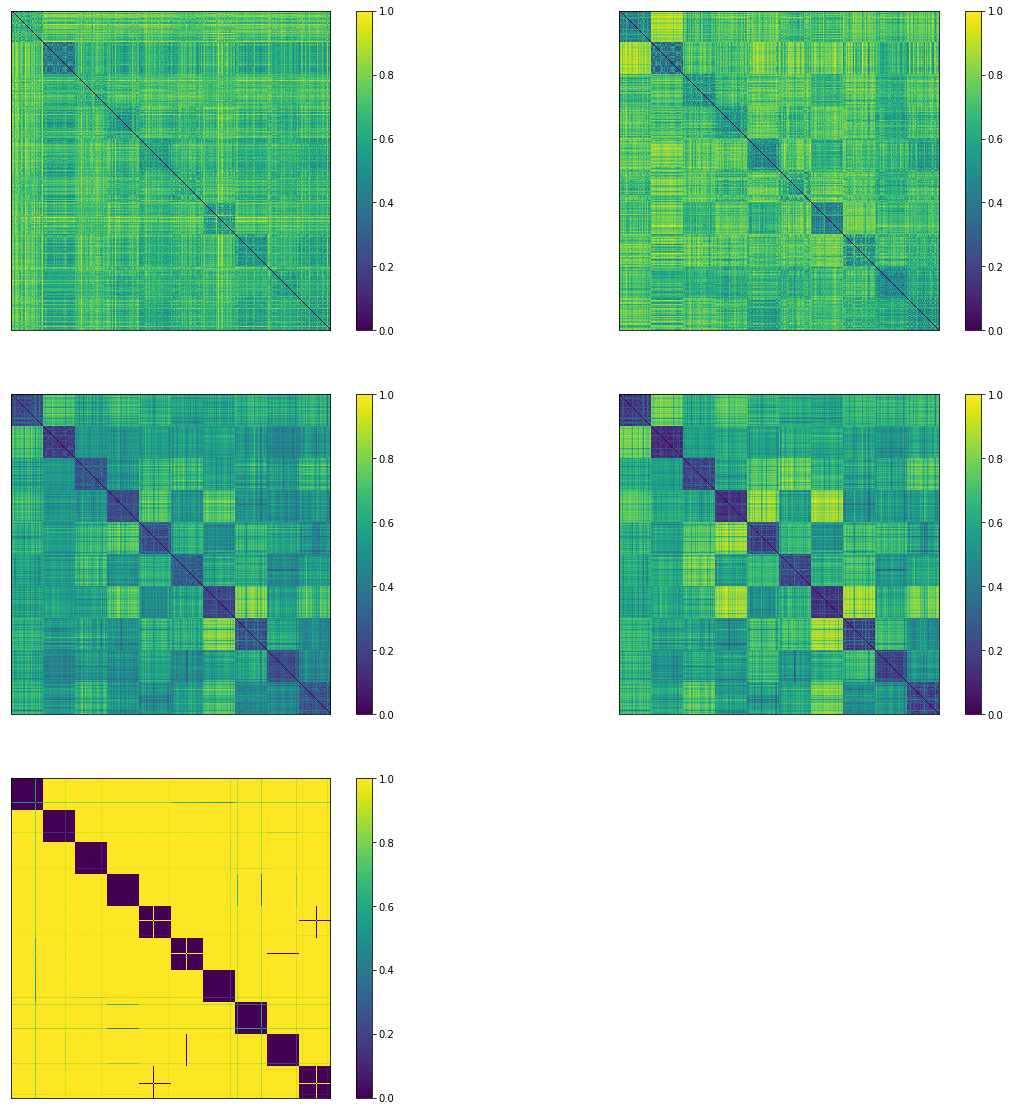

In [90]:
fig = plt.figure(figsize=(20,20))
for i in range(len(dists)):
    plt.subplot(3,2,i+1)
    plt.imshow(dists[i]/np.max(dists[i]))
    plt.xticks([])
    plt.yticks([])
    plt.title('')
    plt.colorbar()
plt.show()